Extract data from Kaggle. 
Source: https://www.kaggle.com/wendykan/lending-club-loan-data/version/1

In [1]:
import pandas as pd
import numpy as np
from datetime import date, timedelta

# import data  

In [2]:
loan_data_origin  = pd.read_csv(r'C:\Users\DDD\Google Drive\Coding\Python\Credit Risk Modeling in Python\Datamart\loan_data_2007_2014.csv')     #import and save as origin dataframe so that always have copy of the original file
loan_data = loan_data_origin.copy() #make copy of the orginal dataframe. Use this dataframe to play

C:\Users\DDD\anaconda3\envs\CreditRiskModeling\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# explore data

In [3]:
loan_data.info()    #explore type of each column of the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

# data cleansing 

In [4]:
loan_data['emp_length'].unique()  #employment length have 'year' string in the value 

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [5]:
# clean up employment length and store in different column
loan_data['emp_length_int'] = loan_data['emp_length'].str.replace('\+ years','')
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace('years','')
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace('n/a',str(0))
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace('< 1 year',str(0))
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace('year','')
loan_data['emp_length_int'] = pd.to_numeric(loan_data['emp_length_int'])        #convert string to numeric
loan_data['emp_length_int'].unique()

array([10.,  0.,  1.,  3.,  8.,  9.,  4.,  5.,  6.,  2.,  7., nan])

In [6]:
loan_data['earliest_cr_line']   #date like but stored as text

0         Jan-85
1         Apr-99
2         Nov-01
3         Feb-96
4         Jan-96
           ...  
466280    Apr-03
466281    Jun-97
466282    Dec-01
466283    Feb-03
466284    Feb-00
Name: earliest_cr_line, Length: 466285, dtype: object

In [7]:
loan_data['earliest_cr_line_date'] = pd.to_datetime(loan_data['earliest_cr_line'], format='%b-%y')  #convert to date. NOTE: when the year is old, it will assume the year 2000 instead of the year 1900 (e.g.: 1966 is converted to 2066)
type(loan_data['earliest_cr_line_date'][0])     #check type if date as expected

pandas._libs.tslibs.timestamps.Timestamp

In [8]:
pd.to_datetime('2017-12-01') - loan_data['earliest_cr_line_date']   #compute time difference in days

0        12022 days
1         6819 days
2         5874 days
3         7974 days
4         8005 days
            ...    
466280    5358 days
466281    7488 days
466282    5844 days
466283    5417 days
466284    6513 days
Name: earliest_cr_line_date, Length: 466285, dtype: timedelta64[ns]

In [9]:
loan_data['mths_since_earliest_cr_line'] = round(
    pd.to_numeric(
        (pd.to_datetime('2017-12-01') - loan_data['earliest_cr_line_date']) / np.timedelta64(1,'M')
    )
)   #compute time difference in months
loan_data['mths_since_earliest_cr_line'] 

0         395.0
1         224.0
2         193.0
3         262.0
4         263.0
          ...  
466280    176.0
466281    246.0
466282    192.0
466283    178.0
466284    214.0
Name: mths_since_earliest_cr_line, Length: 466285, dtype: float64

In [10]:
loan_data['mths_since_earliest_cr_line'].describe() #NOTE: the minimum value is negative. Because of the 2000/1900 year conversion mentioned earlier

count    466256.000000
mean        239.482430
std          93.974829
min        -612.000000
25%         183.000000
50%         225.000000
75%         285.000000
max         587.000000
Name: mths_since_earliest_cr_line, dtype: float64

In [11]:
loan_data.loc[: , ['earliest_cr_line', 'earliest_cr_line_date', 'mths_since_earliest_cr_line']][loan_data['mths_since_earliest_cr_line'] < 0]   #inspect those negative month records

,earliest_cr_line,earliest_cr_line_date,mths_since_earliest_cr_line
1580,Sep-62,2062-09-01,-537.0
1770,Sep-68,2068-09-01,-609.0
2799,Sep-64,2064-09-01,-561.0
3282,Sep-67,2067-09-01,-597.0
3359,Feb-65,2065-02-01,-566.0
...,...,...,...
464003,Jan-68,2068-01-01,-601.0
464260,Jul-66,2066-07-01,-583.0
465100,Oct-67,2067-10-01,-598.0
465500,Sep-67,2067-09-01,-597.0


In [12]:
loan_data['earliest_cr_line_date'][loan_data['mths_since_earliest_cr_line'] < 0] -= timedelta(days=365.25*100)  #deduct 1 century from those dates
loan_data['earliest_cr_line_date'][loan_data['mths_since_earliest_cr_line'] < 0]    #inspect again

<ipython-input-12-1ac7b7a2b21d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data['earliest_cr_line_date'][loan_data['mths_since_earliest_cr_line'] < 0] -= timedelta(days=365.25*100)  #deduct 1 century from those dates


1580     1962-09-01
1770     1968-09-01
2799     1964-09-01
3282     1967-09-01
3359     1965-02-01
            ...    
464003   1968-01-01
464260   1966-07-01
465100   1967-10-01
465500   1967-09-01
465655   1956-01-01
Name: earliest_cr_line_date, Length: 1169, dtype: datetime64[ns]

In [13]:
loan_data['mths_since_earliest_cr_line'] = round(
    pd.to_numeric( 
        (pd.to_datetime('2017-12-01') - loan_data['earliest_cr_line_date']) / np.timedelta64(1,'M')
    )
)   #recompute compute time difference in months
loan_data['mths_since_earliest_cr_line'].describe() #double check that the minimum value is no longer negative

count    466256.000000
mean        242.491078
std          86.928944
min          73.000000
25%         184.000000
50%         226.000000
75%         285.000000
max         887.000000
Name: mths_since_earliest_cr_line, dtype: float64

In [14]:
loan_data['term_int'] = pd.to_numeric(loan_data['term'].str.replace(' months',''))
loan_data['term_int'].describe()

count    466285.000000
mean         42.605334
std          10.719040
min          36.000000
25%          36.000000
50%          36.000000
75%          60.000000
max          60.000000
Name: term_int, dtype: float64

In [15]:
loan_data['issue_date'] = pd.to_datetime(loan_data['issue_d'], format='%b-%y')
loan_data['mths_since_issue_d'] = round(
    pd.to_numeric(
        (pd.to_datetime('2017-12-01') - loan_data['issue_date']) / np.timedelta64(1,'M')
    )
)
loan_data['mths_since_issue_d']

0         72.0
1         72.0
2         72.0
3         72.0
4         72.0
          ... 
466280    47.0
466281    47.0
466282    47.0
466283    47.0
466284    47.0
Name: mths_since_issue_d, Length: 466285, dtype: float64

In [16]:
pd.get_dummies(loan_data['grade'])  #use pd.get_dummies to generate dummy variables out of a variable
pd.get_dummies(loan_data['grade'], prefix='grade', prefix_sep=':')  #can use prefix and prefix separator to create better variable names

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G
0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
466280,0,0,1,0,0,0,0
466281,0,0,0,1,0,0,0
466282,0,0,0,1,0,0,0
466283,1,0,0,0,0,0,0


In [17]:
list_dummies = [
    pd.get_dummies(loan_data['grade'], prefix='grade', prefix_sep=':'),
    pd.get_dummies(loan_data['sub_grade'], prefix='sub_grade', prefix_sep=':'),
    pd.get_dummies(loan_data['home_ownership'], prefix='home_ownership', prefix_sep=':'),
    pd.get_dummies(loan_data['verification_status'], prefix='verification_status', prefix_sep=':'),
    pd.get_dummies(loan_data['loan_status'], prefix='loan_status', prefix_sep=':'),
    pd.get_dummies(loan_data['purpose'], prefix='purpose', prefix_sep=':'),
    pd.get_dummies(loan_data['addr_state'], prefix='addr_state', prefix_sep=':'),
    pd.get_dummies(loan_data['initial_list_status'], prefix='initial_list_status', prefix_sep=':')
]   #do the same for all other categorical variables & put them in a list

In [18]:
loan_data_dummies = pd.concat(list_dummies, axis=1)     #concat all data frames stored in the list, by column (axis=1)
loan_data_dummies

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,sub_grade:A1,sub_grade:A2,sub_grade:A3,...,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
466281,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
466282,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
466283,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [19]:
loan_data = pd.concat([loan_data, loan_data_dummies], axis=1)   #concat with the original loan data
loan_data.columns.values        #check all column names of the dataframe

array(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
       'veri

In [20]:
#check if data is null. Anything null is True (=1), not null is False (=0). Therefore can take the sum to find out how many null rows there are in each column
pd.options.display.max_rows = None
loan_data.isnull().sum()

Unnamed: 0                                                              0
id                                                                      0
member_id                                                               0
loan_amnt                                                               0
funded_amnt                                                             0
funded_amnt_inv                                                         0
term                                                                    0
int_rate                                                                0
installment                                                             0
grade                                                                   0
sub_grade                                                               0
emp_title                                                           27588
emp_length                                                          21008
home_ownership                        

In [21]:
pd.options.display.max_rows = 60
loan_data['total_rev_hi_lim'].fillna(loan_data['funded_amnt'], inplace=True)    #replace null value of column total revolving high limit with the funded amount. 
loan_data['total_rev_hi_lim'].isnull().sum()    #check if the sum if null still exist

0

In [22]:
loan_data['annual_inc'].isnull().sum()

4

In [23]:
loan_data['annual_inc'].mean()

73277.38147046504

In [24]:
loan_data['annual_inc'].fillna(loan_data['annual_inc'].mean(), inplace=True)
loan_data['annual_inc'].isnull().sum()

0

In [25]:
loan_data['mths_since_earliest_cr_line'].fillna(0, inplace=True)
loan_data['acc_now_delinq'].fillna(0, inplace=True)
loan_data['total_acc'].fillna(0, inplace=True)
loan_data['pub_rec'].fillna(0, inplace=True)
loan_data['open_acc'].fillna(0, inplace=True)
loan_data['inq_last_6mths'].fillna(0, inplace=True)
loan_data['delinq_2yrs'].fillna(0, inplace=True)
loan_data['emp_length_int'].fillna(0, inplace=True)

# PD Model

## define dependent variable as Good_Bad

In [26]:
loan_data['loan_status'].value_counts()  #count numbers of each value in column loan_status

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [27]:
loan_data['loan_status'].value_counts()/loan_data['loan_status'].count()    #probability of occurence of each value in coumn loan_status

Current                                                0.480878
Fully Paid                                             0.396193
Charged Off                                            0.091092
Late (31-120 days)                                     0.014798
In Grace Period                                        0.006747
Does not meet the credit policy. Status:Fully Paid     0.004263
Late (16-30 days)                                      0.002612
Default                                                0.001784
Does not meet the credit policy. Status:Charged Off    0.001632
Name: loan_status, dtype: float64

In [28]:
# define good_bad variable as 1 = good = not default. 0 = bad = default
loan_data['good_bad'] = np.where(loan_data['loan_status'].isin([
    'Charged Off','Late (31-120 days)','Default','Does not meet the credit policy. Status:Charged Off'
])          #list all criteria that will be marked as default (bad)
, 0         #default (bad) will be assigned value of 0
, 1         #nondefault (good) will be assigned value of 1
)

## splitting data to train & test

#### overfitting = model is too good at predicting the data. More likely that too dependent on the sample data --> solution = split sample data into training and testing

In [33]:
from sklearn.model_selection import train_test_split

In [35]:
inputs_train, inputs_test, targets_train, targets_test = train_test_split(
        loan_data.drop('good_bad', axis=1),     #remove the dependent variable by column. Use the remaining dataframe to execute the train & test split for the independent variables
        loan_data['good_bad']                   #specify the dependent variable
    )                                           #output of this function contain 4 arrays --> so assign them into dataframes

In [39]:
inputs_train, inputs_test, targets_train, targets_test = train_test_split(
        loan_data.drop('good_bad', axis=1),     #remove the dependent variable by column. Use the remaining dataframe to execute the train & test split for the independent variables
        loan_data['good_bad'],                  #specify the dependent variable
        test_size=0.2,                          #specify the test size proportion %
        random_state=42                         #always shuffle observations in the same random way
    )                                           #output of this function contain 4 arrays --> so assign them into dataframes

In [42]:
inputs_train.shape

(373028, 207)

In [43]:
inputs_test.shape

(93257, 207)

In [44]:
targets_train.shape

(373028,)

In [45]:
targets_test.shape

(93257,)

## data preparation

#### 1. fine classing = splitting variable into equal categories.
#### 2. weight of evidence = compute how much a splitted category explains the differenced of a categorial outcome. The further away from 0, the better the differentiation = ln(%good/%bad)
#### 3. corase classing = group together the categories that have the same weight of evidence.
#### 4. information value = how much information the independent variable explains the dependent variable --> can be used to select the best independent variable --> the higher the IV, the better the explanatory capability = (%good - %bad of each subcategory) * (Weight of Evidence of each respective subcategory), them sum them all up to find Information Value of the dependent variable

### data preparation: example before writing a function: compute Weight of Evidence, Information Value for grade variable

In [48]:
sample_input_df = inputs_train      #copy training data set into a sample dataframe
sample_target_df = targets_train    #copy training data set into a sample dataframe

In [49]:
df1 = pd.concat(
    [sample_input_df['grade'], sample_target_df], 
    axis=1
)   #combine an independent variable with a dependent variable by column
df1.head()

,grade,good_bad
427211,A,1
206088,C,1
136020,A,1
412305,D,0
36159,C,0


In [50]:
df1.groupby(
    df1.columns.values[0],      #group df1 by values of the first column 
    as_index=False              #do not use as index
)[df1.columns.values[1]].count()
#df.groupby(Series1)[Series2].method = group the dataframe df by Series 1, then aggregate Series 2 using the given method

,grade,good_bad
0,A,59759
1,B,109730
2,C,100245
3,D,61498
4,E,28612
5,F,10530
6,G,2654


In [51]:
#since each good value is 1, while bad value is 0 --> taking the average will compute the proportion of good --> 1 minus that average will compute the proportion of bad
df1.groupby(
    df1.columns.values[0],      #group df1 by values of the first column 
    as_index=False              #do not use as index
)[df1.columns.values[1]].mean()

,grade,good_bad
0,A,0.961044
1,B,0.921015
2,C,0.885770
3,D,0.846304
4,E,0.805257
5,F,0.754416
6,G,0.727958


In [52]:
df1 = pd.concat(
    [
        df1.groupby(
            df1.columns.values[0],
            as_index=False
        )[df1.columns.values[1]].count(),
        df1.groupby(
            df1.columns.values[0],
            as_index=False
        )[df1.columns.values[1]].mean()
    ],
    axis=1 
)   #merge the 2 above into 1 dataframe
df1

,grade,good_bad,grade,good_bad
0,A,59759,A,0.961044
1,B,109730,B,0.921015
2,C,100245,C,0.885770
3,D,61498,D,0.846304
4,E,28612,E,0.805257
5,F,10530,F,0.754416
6,G,2654,G,0.727958


In [53]:
df1 = df1.iloc[:, [0,1,3]]  #only retain the 1st, 2nd and 4th column
df1.columns = [df1.columns.values[0], 'n_obs', 'prcnt_good']    #rename columns
df1

,grade,n_obs,prcnt_good
0,A,59759,0.961044
1,B,109730,0.921015
2,C,100245,0.885770
3,D,61498,0.846304
4,E,28612,0.805257
5,F,10530,0.754416
6,G,2654,0.727958


In [58]:
df1['prcnt_n_obs'] = df1['n_obs']/df1['n_obs'].sum()    #proportion of each category = number of observation each category/total number of observations
df1['n_good'] = df1['n_obs'] * df1['prcnt_good']        #number of good in each category
df1['n_bad'] = df1['n_obs'] * (1 - df1['prcnt_good'])        #number of bad in each category
df1

,grade,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad
0,A,59759,0.961044,0.160200,57431.0,2328.0
1,B,109730,0.921015,0.294160,101063.0,8667.0
2,C,100245,0.885770,0.268733,88794.0,11451.0
3,D,61498,0.846304,0.164862,52046.0,9452.0
4,E,28612,0.805257,0.076702,23040.0,5572.0
5,F,10530,0.754416,0.028228,7944.0,2586.0
6,G,2654,0.727958,0.007115,1932.0,722.0


In [63]:
df1['prcnt_n_good'] = df1['n_good']/df1['n_good'].sum()     #proportion of number of good of each category, out of total number of goods = proportion of the column sum
df1['prcnt_n_bad'] = df1['n_bad']/df1['n_bad'].sum()        #likewise for the proportion of number of bad
df1['WoE'] = np.log(df1['prcnt_n_good']/df1['prcnt_n_bad']) #compute Weight of Evidence
df1

,grade,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE
0,A,59759,0.961044,0.160200,57431.0,2328.0,0.172855,0.057090,1.107830
1,B,109730,0.921015,0.294160,101063.0,8667.0,0.304178,0.212541,0.358476
2,C,100245,0.885770,0.268733,88794.0,11451.0,0.267251,0.280813,-0.049503
3,D,61498,0.846304,0.164862,52046.0,9452.0,0.156647,0.231792,-0.391843
4,E,28612,0.805257,0.076702,23040.0,5572.0,0.069345,0.136642,-0.678267
5,F,10530,0.754416,0.028228,7944.0,2586.0,0.023910,0.063417,-0.975440
6,G,2654,0.727958,0.007115,1932.0,722.0,0.005815,0.017706,-1.113459


In [65]:
df1 = df1.sort_values(['WoE'])  #sort by WoE
df1 = df1.reset_index(drop=True)    #reset index, drop old index
df1

,grade,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE
0,G,2654,0.727958,0.007115,1932.0,722.0,0.005815,0.017706,-1.113459
1,F,10530,0.754416,0.028228,7944.0,2586.0,0.023910,0.063417,-0.975440
2,E,28612,0.805257,0.076702,23040.0,5572.0,0.069345,0.136642,-0.678267
3,D,61498,0.846304,0.164862,52046.0,9452.0,0.156647,0.231792,-0.391843
4,C,100245,0.885770,0.268733,88794.0,11451.0,0.267251,0.280813,-0.049503
5,B,109730,0.921015,0.294160,101063.0,8667.0,0.304178,0.212541,0.358476
6,A,59759,0.961044,0.160200,57431.0,2328.0,0.172855,0.057090,1.107830


In [69]:
df1['diff_prcnt_good'] = df1['prcnt_good'].diff().abs()     #compute row difference in column percentage good. Take absolute to see the increase from 1 class to the next
df1['diff_WoE'] = df1['WoE'].diff().abs()     #compute row difference in column WoE
df1

,grade,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE
0,G,2654,0.727958,0.007115,1932.0,722.0,0.005815,0.017706,-1.113459,NaN,NaN
1,F,10530,0.754416,0.028228,7944.0,2586.0,0.023910,0.063417,-0.975440,0.026458,0.138019
2,E,28612,0.805257,0.076702,23040.0,5572.0,0.069345,0.136642,-0.678267,0.050841,0.297173
3,D,61498,0.846304,0.164862,52046.0,9452.0,0.156647,0.231792,-0.391843,0.041047,0.286424
4,C,100245,0.885770,0.268733,88794.0,11451.0,0.267251,0.280813,-0.049503,0.039466,0.342340
5,B,109730,0.921015,0.294160,101063.0,8667.0,0.304178,0.212541,0.358476,0.035245,0.407979
6,A,59759,0.961044,0.160200,57431.0,2328.0,0.172855,0.057090,1.107830,0.040028,0.749353


In [70]:
df1['IV'] = (df1['prcnt_n_good'] - df1['prcnt_n_bad']) * df1['WoE'] #for each category (= each row), compute the difference between % good and % bad then multiply by WoE of the category
df1['IV'] = df1['IV'].sum()     #sum all IV value across all categories
df1     #value in column IV is the same for each category because it represents the value of the grade variable

,grade,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,G,2654,0.727958,0.007115,1932.0,722.0,0.005815,0.017706,-1.113459,NaN,NaN,0.288636
1,F,10530,0.754416,0.028228,7944.0,2586.0,0.023910,0.063417,-0.975440,0.026458,0.138019,0.288636
2,E,28612,0.805257,0.076702,23040.0,5572.0,0.069345,0.136642,-0.678267,0.050841,0.297173,0.288636
3,D,61498,0.846304,0.164862,52046.0,9452.0,0.156647,0.231792,-0.391843,0.041047,0.286424,0.288636
4,C,100245,0.885770,0.268733,88794.0,11451.0,0.267251,0.280813,-0.049503,0.039466,0.342340,0.288636
5,B,109730,0.921015,0.294160,101063.0,8667.0,0.304178,0.212541,0.358476,0.035245,0.407979,0.288636
6,A,59759,0.961044,0.160200,57431.0,2328.0,0.172855,0.057090,1.107830,0.040028,0.749353,0.288636


### data preparation: write a function to compute Weight of Evidence, Information Value for any discrete variable

In [71]:
def woe_discrete(df, discrete_variable_name, good_bad_df):
    df = pd.concat(
        [df[discrete_variable_name], good_bad_df],
        axis=1
    )       #concat independent variable and dependent variable
    df = pd.concat(
        [
            df.groupby(
                df.columns.values[0],
                as_index=False
            )[df.columns.values[1]].count(),
            df.groupby(
                df.columns.values[0],
                as_index=False
            )[df.columns.values[1]].mean()
        ],
        axis=1 
    )   #compute count of each category in the dependent variable and % of good in each category
    df = df.iloc[:, [0,1,3]]  #only retain the 1st, 2nd and 4th column
    df.columns = [df.columns.values[0], 'n_obs', 'prcnt_good']    #rename columns
    df['prcnt_n_obs'] = df['n_obs']/df['n_obs'].sum()    #proportion of each category = number of observation each category/total number of observations
    
    df['n_good'] = df['n_obs'] * df['prcnt_good']        #number of good in each category
    df['n_bad'] = df['n_obs'] * (1 - df['prcnt_good'])        #number of bad in each category
    
    df['prcnt_n_good'] = df['n_good']/df['n_good'].sum()     #proportion of number of good of each category, out of total number of goods = proportion of the column sum
    df['prcnt_n_bad'] = df['n_bad']/df['n_bad'].sum()        #likewise for the proportion of number of bad
    
    df['WoE'] = np.log(df['prcnt_n_good']/df['prcnt_n_bad']) #compute Weight of Evidence
    
    df = df.sort_values(['WoE'])  #sort by WoE
    df = df.reset_index(drop=True)    #reset index, drop old index
    
    df['diff_prcnt_good'] = df['prcnt_good'].diff().abs()     #compute row difference in column percentage good. Take absolute to see the increase from 1 class to the next
    df['diff_WoE'] = df['WoE'].diff().abs()     #compute row difference in column WoE
    
    df['IV'] = (df['prcnt_n_good'] - df['prcnt_n_bad']) * df['WoE'] #for each category (= each row), compute the difference between % good and % bad then multiply by WoE of the category
    df['IV'] = df['IV'].sum()		#sum all IV value across all categories

    return df

In [73]:
df_temp = woe_discrete(sample_input_df, 'grade', sample_target_df)  #test the above function for grade variable
df_temp

,grade,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,G,2654,0.727958,0.007115,1932.0,722.0,0.005815,0.017706,-1.113459,NaN,NaN,0.288636
1,F,10530,0.754416,0.028228,7944.0,2586.0,0.023910,0.063417,-0.975440,0.026458,0.138019,0.288636
2,E,28612,0.805257,0.076702,23040.0,5572.0,0.069345,0.136642,-0.678267,0.050841,0.297173,0.288636
3,D,61498,0.846304,0.164862,52046.0,9452.0,0.156647,0.231792,-0.391843,0.041047,0.286424,0.288636
4,C,100245,0.885770,0.268733,88794.0,11451.0,0.267251,0.280813,-0.049503,0.039466,0.342340,0.288636
5,B,109730,0.921015,0.294160,101063.0,8667.0,0.304178,0.212541,0.358476,0.035245,0.407979,0.288636
6,A,59759,0.961044,0.160200,57431.0,2328.0,0.172855,0.057090,1.107830,0.040028,0.749353,0.288636


### data preparation: visualise Weight of Evidence

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns   #seaborn is a nice skin for matplotlib
sns.set()

In [76]:
#function to create visualisation from a given dataframe
def plot_woe(
    df_woe,             #given dataframe
    rotation_xLabel=0   #some long value would have to be rotated to be able to read. Default value= 0 = no rotation
    ):
    x_axis = np.array(
        df_woe.iloc[:, 0].apply(str)    #x-axis shall be the first column of the given dataframe, convert all values to string
    )   #matplotlib optimised to work with numpy, not so much with df --> so put the x-axis values into numpy's array
    y_axis = df_woe['WoE']
    plt.figure(figsize=(18,6))  #figure size 18x6 inch
    plt.plot(x_axis, y_axis, marker='o', linestyle='--', color='k')  #plot x and y, market is dot, line is dash, color of the value is black
    plt.xlabel(df_woe.columns[0])    #x-axis label
    plt.ylabel('Weight of Evidence')    #y-axis label
    plt.title(str('Weight of Evidence by ' + df_woe.columns[0]))    #chart title
    plt.xticks(rotation = rotation_xLabel)  #rotate x-axis values by the given parameter

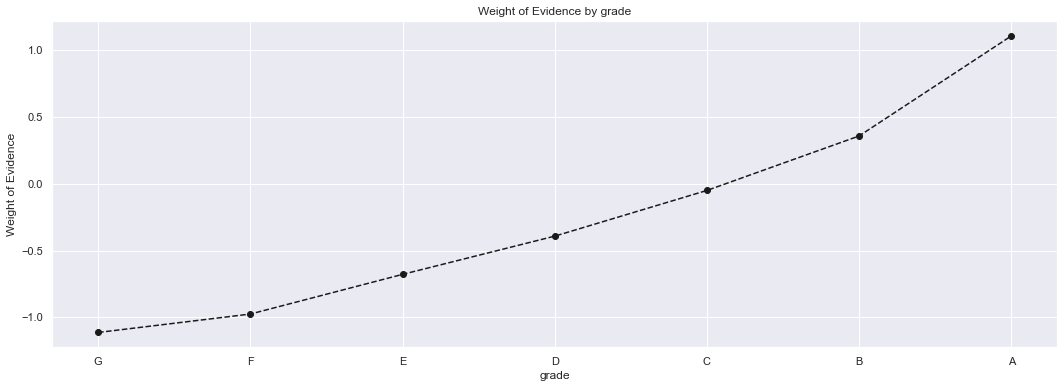

In [77]:
plot_woe(df_temp)